# Double DQN - Lunar Lander Environment

# Step 1: Imports and Setup
We set up the environment and device. We use deque for the efficient memory buffer.

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


# Step 2: Replay Buffer & Neural Network

Replay Buffer: Stores experiences $(S, A, R, S', Done)$ and samples them randomly to break correlations between consecutive frames.

DQN: Maps the current state (8 inputs for LunarLander) to Q-values for every possible action (4 outputs).

In [2]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (torch.tensor(states, dtype=torch.float32).to(DEVICE),
                torch.tensor(actions, dtype=torch.int64).to(DEVICE),
                torch.tensor(rewards, dtype=torch.float32).to(DEVICE),
                torch.tensor(next_states, dtype=torch.float32).to(DEVICE),
                torch.tensor(dones, dtype=torch.float32).to(DEVICE))
    
    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

    def forward(self, x):
        return self.net(x)

def select_action(model, state, epsilon, act_dim):
    # Exploration: random action
    if random.random() < epsilon:
        return random.randrange(act_dim)
    # Exploitation: best action according to the network
    with torch.no_grad():
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(DEVICE)
        return int(torch.argmax(model(state)).item())

# Step 3: The Dual-Mode Training Function
This function contains the core logic. It accepts a double_dqn boolean flag.

Standard DQN: The Target Net finds the max Q-value directly. It is optimistic.

Double DQN: The Policy Net chooses the best action (argmax), and the Target Net calculates the value of that specific action. This separation prevents the "optimism" from spiraling out of control.

In [3]:
def run_lunar_experiment(exp_name, double_dqn=True, total_episodes=400):
    env = gym.make('LunarLander-v3')
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    
    # Hyperparameters
    lr = 5e-4
    gamma = 0.99
    batch_size = 128
    target_update_freq = 200
    buffer_capacity = 100000
    min_buffer_size = 1000
    epsilon_decay = 10000 # Decay based on steps, not episodes
    
    # Initialize Networks
    policy_net = DQN(obs_dim, action_dim).to(DEVICE)
    target_net = DQN(obs_dim, action_dim).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    
    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay_buffer = ReplayBuffer(buffer_capacity)
    
    epsilon_start = 1.0
    epsilon_final = 0.01
    steps_done = 0
    rewards_history = []
    q_value_history = [] # To track Maximization Bias

    print(f"--- Starting: {exp_name} | Double: {double_dqn} ---")

    for episode in range(total_episodes):
        state, _ = env.reset()
        episode_reward = 0
        episode_q_vals = []
        
        while True:
            # Epsilon Decay (Exponential)
            epsilon = epsilon_final + (epsilon_start - epsilon_final) * np.exp(-1. * steps_done / epsilon_decay)
            
            action = select_action(policy_net, state, epsilon, action_dim)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            replay_buffer.push(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            steps_done += 1

            if len(replay_buffer) >= min_buffer_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)

                with torch.no_grad():
                    if double_dqn:
                        # --- DOUBLE DQN LOGIC ---
                        # 1. Action Selection: Policy Net decides "which" action is best
                        best_actions = policy_net(next_states).argmax(1)
                        # 2. Action Evaluation: Target Net calculates the value of THAT action
                        next_q = target_net(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                    else:
                        # --- STANDARD DQN LOGIC ---
                        # Target Net selects AND evaluates (Max operator). This causes bias.
                        next_q = target_net(next_states).max(1)[0]
                    
                    target = rewards + (1 - dones) * gamma * next_q

                q_values = policy_net(states)
                current = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
                
                # Save average Q-value for analysis
                episode_q_vals.append(current.mean().item())

                loss = nn.SmoothL1Loss()(current, target)
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_value_(policy_net.parameters(), 1.0)
                optimizer.step()

            if steps_done % target_update_freq == 0:
                target_net.load_state_dict(policy_net.state_dict())

            if done:
                break
        
        rewards_history.append(episode_reward)
        q_value_history.append(np.mean(episode_q_vals) if episode_q_vals else 0)

        if episode % 50 == 0:
            print(f"Ep {episode}: Reward {episode_reward:.2f} | Avg Q: {q_value_history[-1]:.2f} | Eps: {epsilon:.2f}")

    env.close()
    return rewards_history, q_value_history

# Step 4: Running the Comparison

We run the training loop twice to collect data for comparison.

In [4]:
results = {}
N_EPISODES = 400

# 1. Train Standard DQN
print("Collecting data for Standard DQN...")
res_dqn = run_lunar_experiment('DQN', double_dqn=False, total_episodes=N_EPISODES)
results['Standard DQN'] = res_dqn

# 2. Train Double DQN
print("\nCollecting data for Double DQN...")
res_ddqn = run_lunar_experiment('Double DQN', double_dqn=True, total_episodes=N_EPISODES)
results['Double DQN'] = res_ddqn

/Users/albertovaglio/Desktop/DQN/dqn_env/lib/python3.13/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


--- Starting: DQN | Double: False ---
Ep 0: Reward -102.34 | Avg Q: 0.00 | Eps: 0.99
Ep 50: Reward -95.65 | Avg Q: 12.65 | Eps: 0.54
Ep 100: Reward 182.42 | Avg Q: 18.09 | Eps: 0.02
Ep 150: Reward 107.06 | Avg Q: 20.48 | Eps: 0.01
Ep 200: Reward 252.89 | Avg Q: 16.36 | Eps: 0.01
Ep 250: Reward 267.98 | Avg Q: 19.36 | Eps: 0.01
Ep 300: Reward 231.53 | Avg Q: 20.47 | Eps: 0.01
Ep 350: Reward 238.35 | Avg Q: 25.48 | Eps: 0.01

--- Starting: Double DQN | Double: True ---
Ep 0: Reward -89.22 | Avg Q: 0.00 | Eps: 0.99
Ep 50: Reward -17.58 | Avg Q: 22.53 | Eps: 0.58
Ep 100: Reward -3.08 | Avg Q: 32.70 | Eps: 0.06
Ep 150: Reward 235.58 | Avg Q: 21.75 | Eps: 0.01
Ep 200: Reward 256.50 | Avg Q: 18.37 | Eps: 0.01
Ep 250: Reward 278.66 | Avg Q: 17.02 | Eps: 0.01
Ep 300: Reward -15.39 | Avg Q: 17.99 | Eps: 0.01
Ep 350: Reward 280.46 | Avg Q: 21.45 | Eps: 0.01


# Step 5: Visualizing Maximization Bias

This plot will show the "Total Reward" (top) and the "Estimated Q-Values" (bottom).

What to look for: You will likely see that Standard DQN has excessively high Q-values (e.g., estimating 300+ points) even if the actual reward is lower. Double DQN should have lower, more realistic estimates.

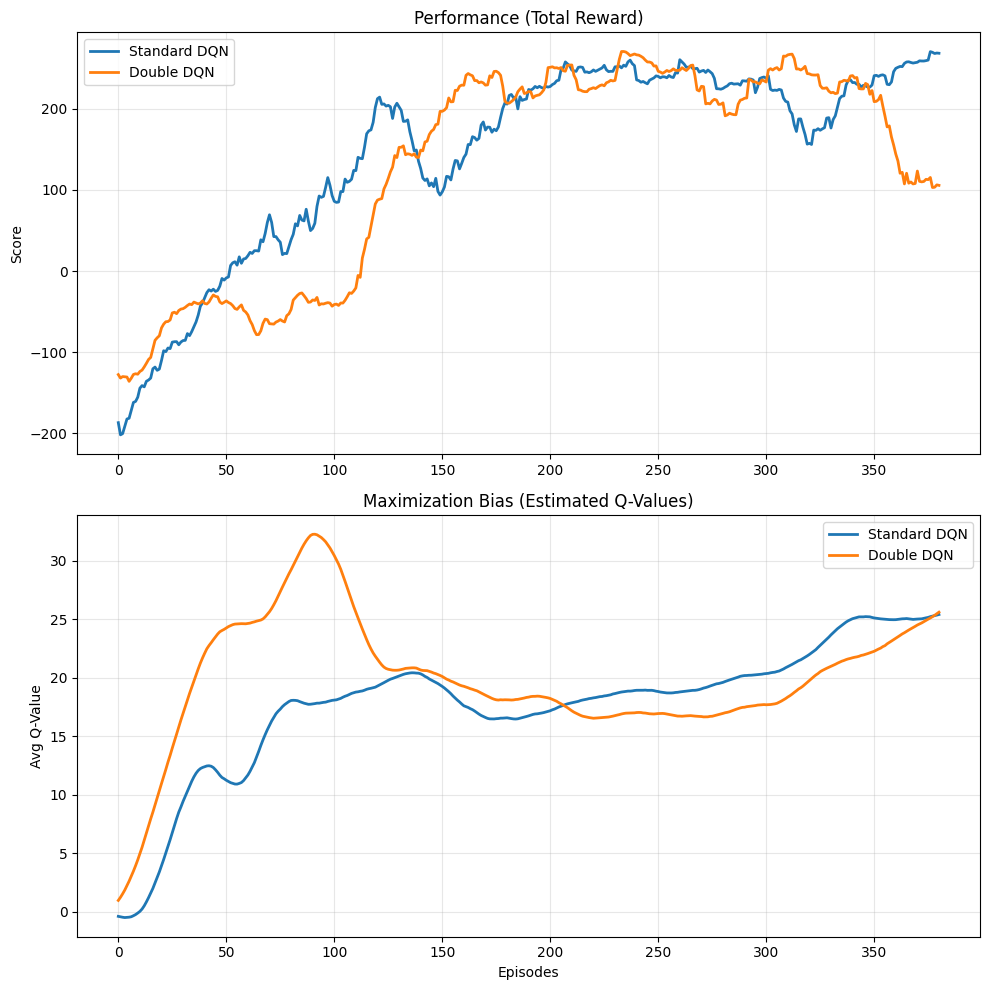

In [5]:
def plot_dual_comparison(results):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
    window = 20
    
    for name, (rewards, q_vals) in results.items():
        # Plot Rewards
        smooth_r = np.convolve(rewards, np.ones(window)/window, mode='valid')
        ax1.plot(smooth_r, label=name, linewidth=2)
            
        # Plot Q-Values (Maximization Bias)
        smooth_q = np.convolve(q_vals, np.ones(window)/window, mode='valid')
        ax2.plot(smooth_q, label=name, linewidth=2)

    ax1.set_title("Performance (Total Reward)")
    ax1.set_ylabel("Score")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.set_title("Maximization Bias (Estimated Q-Values)")
    ax2.set_ylabel("Avg Q-Value")
    ax2.set_xlabel("Episodes")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_dual_comparison(results)